# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, SeparableConv1D, MaxPooling1D

Using TensorFlow backend.


# Read Data

In [2]:
x_train_df = pd.read_csv('x_train.csv', index_col=0)
x_test_df = pd.read_csv('x_test.csv', index_col=0)
y_train_series = pd.read_csv('y_train.csv', index_col=0, header=None)
y_test_series = pd.read_csv('y_test.csv', index_col=0, header=None)

# Just grab the values for training.
x_train = x_train_df.values
x_test = x_test_df.values
y_train = y_train_series.values
y_test = y_test_series.values
print('Data loaded.')

Data loaded.


# Contants for Reshaping

In [3]:
# How many weeks are we using for batches?
num_weeks = 4

# How many full weeks do we have?
five_min_per_week = int((1/5) * 60 * 24 * 7)
# Given the shape of our data, how many weeks are there? (round down)
weeks_train = np.floor(x_train.shape[0] / five_min_per_week).astype(int)
weeks_test = np.floor(x_test.shape[0] / five_min_per_week).astype(int)
# Given how many weeks we have and assuming we train with 4 week batches, how
# many batches will we have?
batches_train = int(np.floor(weeks_train) / num_weeks)
batches_test = int(np.floor(weeks_test) / num_weeks)
# Determine the ending index of the data we'll keep (trim off the end)
keep_train = five_min_per_week * batches_train
keep_test = five_min_per_week * batches_test
# Number of timesteps in a "month"
t_per_m = five_min_per_week * num_weeks
# Num features for convenience.
num_f = x_train.shape[1]

print('Constants for reshaping defined.')

Constants for reshaping defined.


# Reshape Data for 1D CNN

In [4]:
x_1d_train = np.zeros((batches_train, t_per_m, num_f))
# y_1d_train = np.zeros((batches_train, t_per_m))
y_1d_train = np.zeros((batches_train, 1))

x_1d_test = np.zeros((batches_test, t_per_m, num_f))
# y_1d_test = np.zeros((batches_test, t_per_m))
y_1d_test = np.zeros((batches_test, 1))

# Loop and put each month into the correct spot.
for b in range(x_1d_train.shape[0]):
    # Determine starting and ending index:
    start_idx = int(b * t_per_m)
    end_idx = start_idx + t_per_m

    # Drop the data in.
    x_1d_train[b, :, :] = x_train[start_idx:end_idx, :]
    y_1d_train[b] = y_train[end_idx]
#   y_1d_train[b, :] = y_train[start_idx:end_idx, :].ravel()
    
        # Repeat for the testing data. However, we'll bail if we get an index error.
    try:
      x_1d_test[b, :, :] = x_test[start_idx:end_idx, :]
#       y_1d_test[b, :] = y_test[start_idx:end_idx, :].ravel()
      y_1d_test[b, :] = y_test[end_idx].ravel()
      
    except IndexError:
      pass

print('Data reshaped for 1D CNN')

Data reshaped for 1D CNN


# Create and Train 1D CNN

In [5]:
# https://keras.io/layers/convolutional/
cnn1d = Sequential()
# Kernel size of 36 - 3 hours of 5 minute windows?
# cnn1d.add(Conv1D(filters=8, kernel_size=36, padding='same',
#                  input_shape=(t_per_m, num_f)))
cnn1d.add(SeparableConv1D(filters=32, kernel_size=36, padding='same',
                 input_shape=(t_per_m, num_f)))
cnn1d.add(MaxPooling1D(pool_size=12))
cnn1d.add(SeparableConv1D(filters=32, kernel_size=36, padding='same',
                 input_shape=(t_per_m, num_f)))
cnn1d.add(MaxPooling1D(pool_size=12))
cnn1d.add(Flatten())
cnn1d.add(Dense(512, activation='relu'))
cnn1d.add(Dropout(0.25))
cnn1d.add(Dense(1))
          
cnn1d.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

cnn1d.summary()

cnn1d.fit(x_1d_train, y_1d_train, epochs=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d_1 (Separabl (None, 8064, 32)          1256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 672, 32)           0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 672, 32)           2208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 56, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_1 (Dense)      

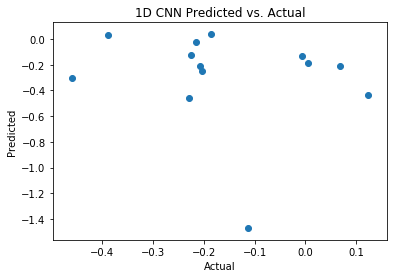

In [6]:
y_pred = cnn1d.predict(x_1d_test)

plt.scatter(y_1d_test.flatten(), y_pred.flatten())
# If our predictions were perfect, they'd fall exactly on this line.
# plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('1D CNN Predicted vs. Actual')
plt.show()